In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from IPython.display import Image

In [2]:
import functions

In [3]:
from gwpy.timeseries import TimeSeries
from gwpy.time import from_gps,to_gps
from gwpy.segments import DataQualityFlag
#plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

### This project is about Scattering noise. Here, I provide a brief explanation of light scattering noise. In order to detect gravitational waves, aLigo needs to maintain a sensitivity of 10^-19 m/sqrt(Hz). And this requires isolating the detector from as much noise as possible. Seismic noise affects the detector in the frequency band 10 to 60 Hz and is coupled through high ground motion. Light Scattering is a form of noise that is dominant during high ground motion. This particular project is about back scattering. As shown in the figure below, some part of the light after getting transmitted from the lowest Main chain mirror, gets scattered and hits the Gold ESD on the reaction chain lower stage mirror. During high ground motion, this distance between mirrors at the lower stage of Reaction and Main chain changes quite a bit. Now since the ESD is made up of Gold, it has very high reflectivity and almost all of the light is reflected back. A part of this back reflected light, is transmitted back to the field in the arms.  When this back scattered light interferes with the field in the arms, it changes the total phase. This is because the back scattered light has an extra phase, due to the extra distance it has travelled. And this phase noise shows up scattering arches in the time-frequency plane. 

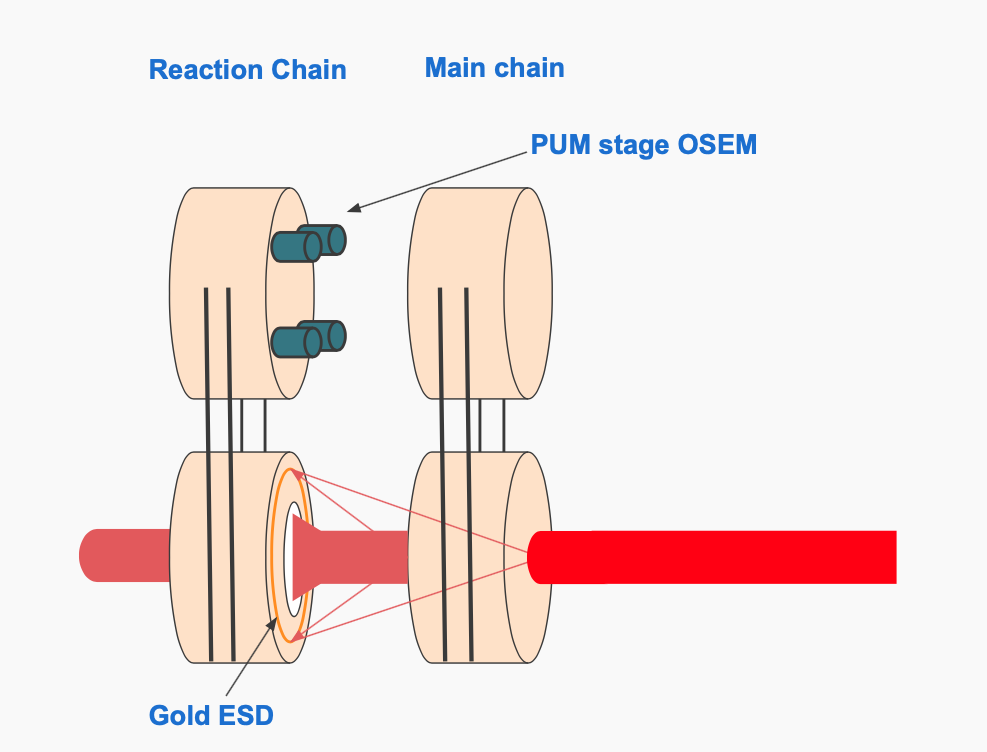

In [4]:
Image(filename='mirror-diagram.png')

### Scattering arch in time-frequency plane

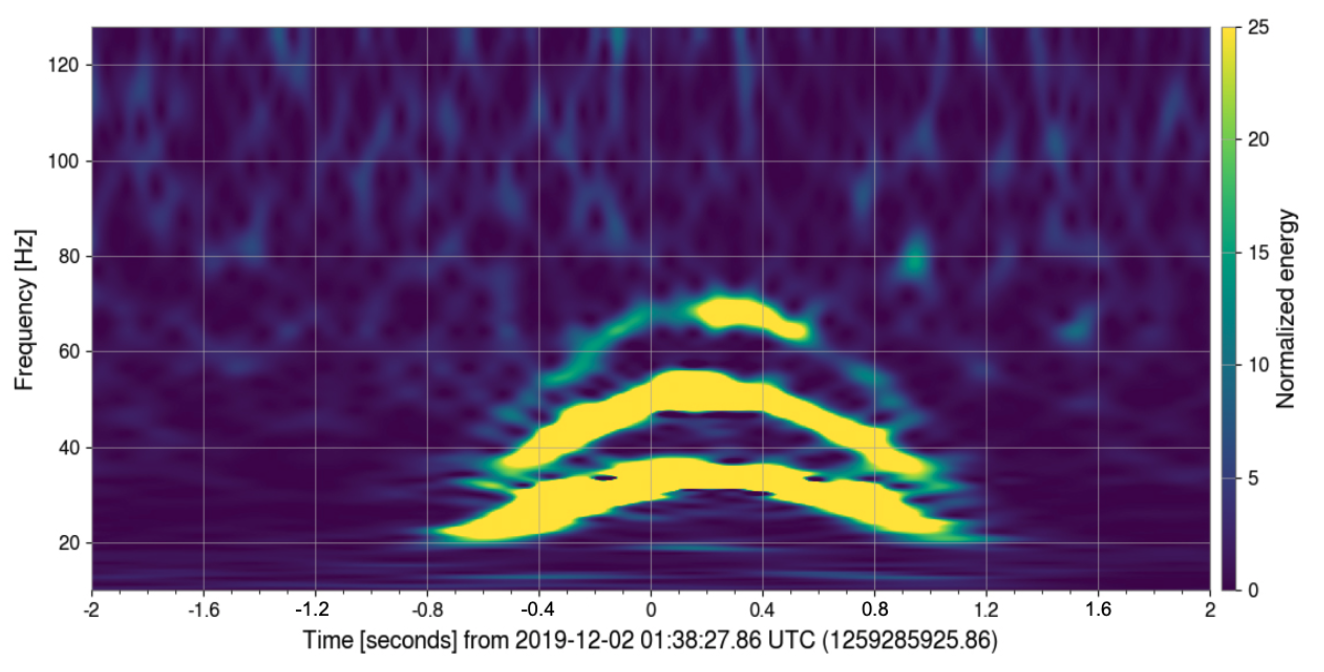

In [5]:
Image(filename='scattering_arch.png')

## RC tracking
### In order to reduce this noise, a technique known as RC tracking or Reaction Chain tracking was implemented. RC tracking reduced the relative motion between the two mirrors at the lower stage. This decreased the resulting phase change of the back scattered light, which in turn reduced the noise. To measure the impact of this technique, here in this notebook, I look at the ground motion before and after RC tracking was implemented. And I compare that with the SNR (loudness) of the noise before and after the RC tracking. I show that even though there was not a significant change in the ground motion in microseism band (0.1 Hz - 0.3 Hz)  and earthquake band (0.03 Hz - 0.1 Hz), the change in SNR of noise was very significant. This, I accomplish by calculating the p-value with the null hypothesis that there is no change in microseism, earthquake and SNR. 

#### Parameters

In [6]:
t1_L1 = to_gps('2019-11-01')
t1a_L1 = to_gps('2020-01-07')
t2_L1 = to_gps('2020-01-10')
t2a_L1 = to_gps('2020-02-08')

t1_H1 = to_gps('2019-11-01')
t1a_H1 = to_gps('2020-01-14')
t2_H1 = to_gps('2020-01-15')
t2a_H1 = to_gps('2020-02-28')

#### Noise data file

In [7]:
df_L1_gspy = pd.read_csv('/Users/siddharth/Desktop/Datasciencenotebooks/gspyO3bNov1_Feb8.csv')

In [8]:
df_L1_gspy = functions.dataframe_clean(df_L1_gspy,'GPStime',snr=8,conf=0.9)

In [9]:
df_L1_gspy.head()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,1.256657e+09,36.625,10.461,1.410000e-22,3351.738,1.250,6665.644531,0.0,0.0,0.999,Q2EvV9kpMy,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,22.627
1,1.256658e+09,23.750,63.003,2.470000e-21,3980.917,4.781,7939.132813,0.0,0.0,0.907,TItGRTVwo6,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,45.255
2,1.256658e+09,19.519,24.601,2.410000e-21,3981.425,2.500,7938.115723,0.0,0.0,0.993,riAS999mi6,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,45.255
3,1.256675e+09,30.734,9.287,1.510000e-22,32.286,1.219,23.926611,0.0,0.0,0.988,9kWd00047e,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
4,1.256675e+09,26.909,8.809,2.130000e-22,362.945,1.250,688.058472,0.0,0.0,0.984,VxPpsRSkTB,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314


In [10]:
segsL1_pre,durL1_pre = functions.segs_and_dur(t1_L1,t1a_L1,'L1')
segsL1_post,durL1_post = functions.segs_and_dur(t2_L1,t2a_L1,'L1')

In [11]:
### Ratio of duration of Pre and Post RC tracking.
durfacL1 = 2.38

### Ground motion files

In [12]:
datapre_L1 = np.load('preRzero_O3bX_observe_only_NEW.py',allow_pickle=True,encoding='latin1').item()
datapost_L1 = np.load('postRzero_O3bX_observe_only_NEW.npy',allow_pickle=True,encoding='latin1').item()

#### Microseism band

In [13]:
micro_pre_L1 =  TimeSeries(datapre_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe'],
                              times=datapre_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe_times'])
micro_post_L1 = TimeSeries(datapost_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe'],
                               times=datapost_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe_times'])

In [14]:
count_micropre,division_micropre = np.histogram(micro_pre_L1,bins=np.arange(100,2100,100))
count_micropost,division_micropost = np.histogram(micro_post_L1,bins=np.arange(100,2100,100))

In [15]:
division_micropre

<TimeSeries([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,
              800.,  900., 1000., 1100., 1200., 1300., 1400.,
             1500., 1600., 1700., 1800., 1900., 2000.]
            unit=Unit(dimensionless),
            t0=<Quantity 1.25665566e+09 s>,
            dt=None,
            name=None,
            channel=None)>

#### Earthquake band

In [16]:
eq_pre_L1 = TimeSeries(datapre_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe'],
                       times = datapre_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe_times'])
eq_post_L1 = TimeSeries(datapost_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe'],
                        times = datapost_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe_times'])

In [17]:
count_eqpre,division_eqpre = np.histogram(eq_pre_L1,bins=np.arange(0,1050,50))
count_eqpost,division_eqpost = np.histogram(eq_post_L1,bins=np.arange(0,1050,50))

#### SNR

In [18]:
count_presnrL1,division_presnrL1 = np.histogram(df_L1_gspy[(df_L1_gspy.GPStime<to_gps('2020-01-07'))]['snr'],bins=np.arange(10,110,5))
count_postsnrL1,division_postsnrL1 = np.histogram(df_L1_gspy[(df_L1_gspy.GPStime>=to_gps('2020-01-10'))]['snr'],bins=np.arange(10,110,5))

### Compare Ground motion and SNR Pre and Post RC tracking

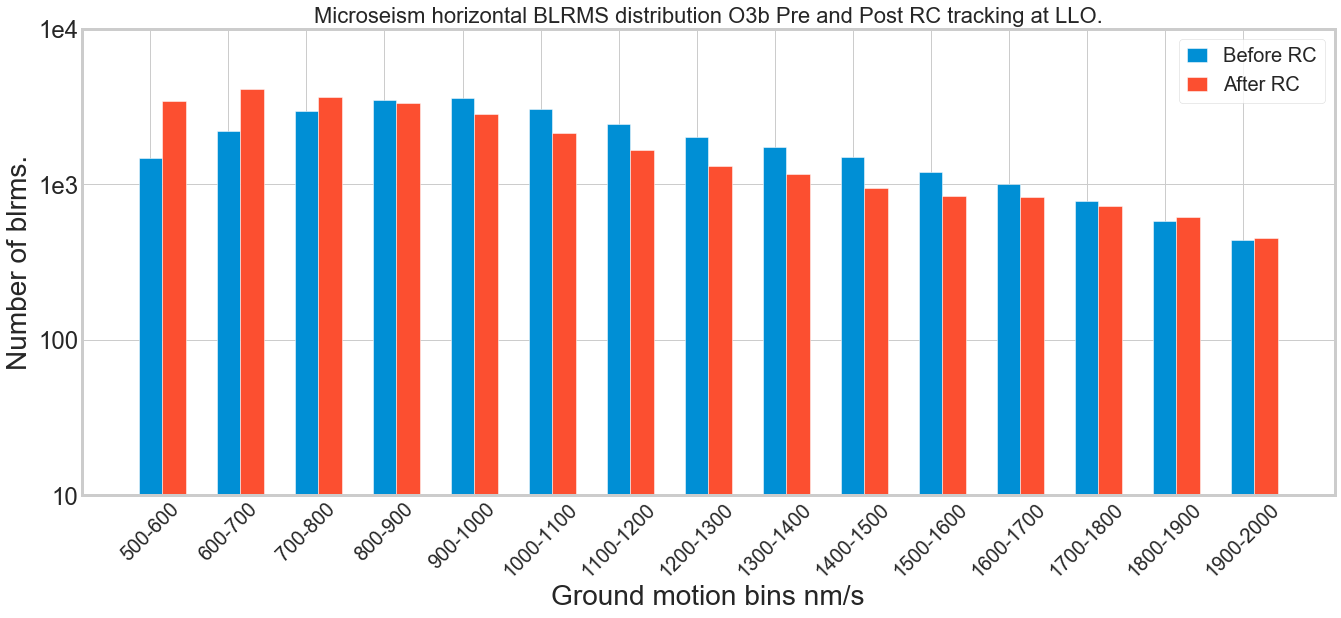

In [44]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_micropost[4:])-1)
w = 0.3
#print(tcks)
plt.bar(x,count_micropre[4:]/durfacL1,width=w,label='Before RC')
plt.bar(x+w,count_micropost[4:],width=w,label='After RC')
tcks = [str(int(division_micropost[i]))+'-'+str(int(division_micropost[i+1])) for i in range(4,len(division_micropost)-1)]
plt.xticks(x,tcks,fontsize=20,rotation='45')
#plt.grid(True,which='both')
plt.yscale('log')
plt.yticks([10,100,1000,1e4],[10,100,'1e3','1e4'],fontsize=24)
plt.ylim(10,1e4)
plt.xlabel('Ground motion bins nm/s',fontsize=28)
plt.ylabel('Number of blrms.',fontsize=28)
plt.title('Microseism horizontal BLRMS distribution O3b Pre and Post RC tracking at LLO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

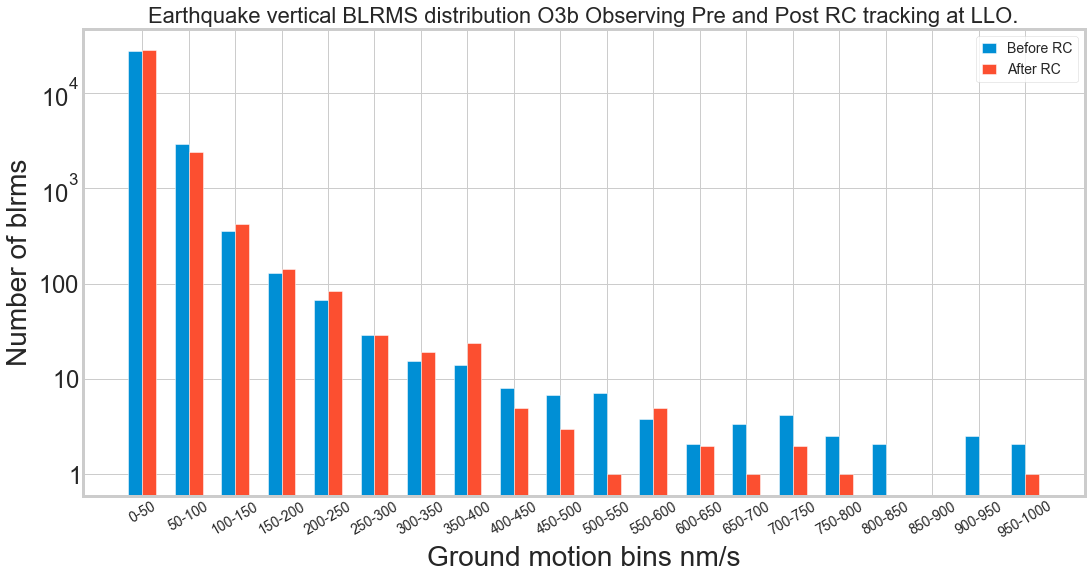

In [45]:
plt.figure(figsize=(16,8))
x = np.arange(len(division_eqpost)-1)
w = 0.3
plt.bar(x,count_eqpre/durfacL1,width=w,label='Before RC')
plt.bar(x+w,count_eqpost,width=w,label='After RC')
tcks = [str(int(division_eqpost[i]))+'-'+str(int(division_eqpost[i+1])) for i in range(len(division_eqpost)-1)]
plt.xticks(x + w/2,tcks,rotation='-330')
plt.yscale('log')
plt.xlabel('Ground motion bins nm/s',fontsize=28)
plt.yticks(fontsize=24)
plt.ylabel('Number of blrms',fontsize=28)
plt.title('Earthquake vertical BLRMS distribution O3b Observing Pre and Post RC tracking at LLO.',fontsize=22)
plt.legend()
plt.show()

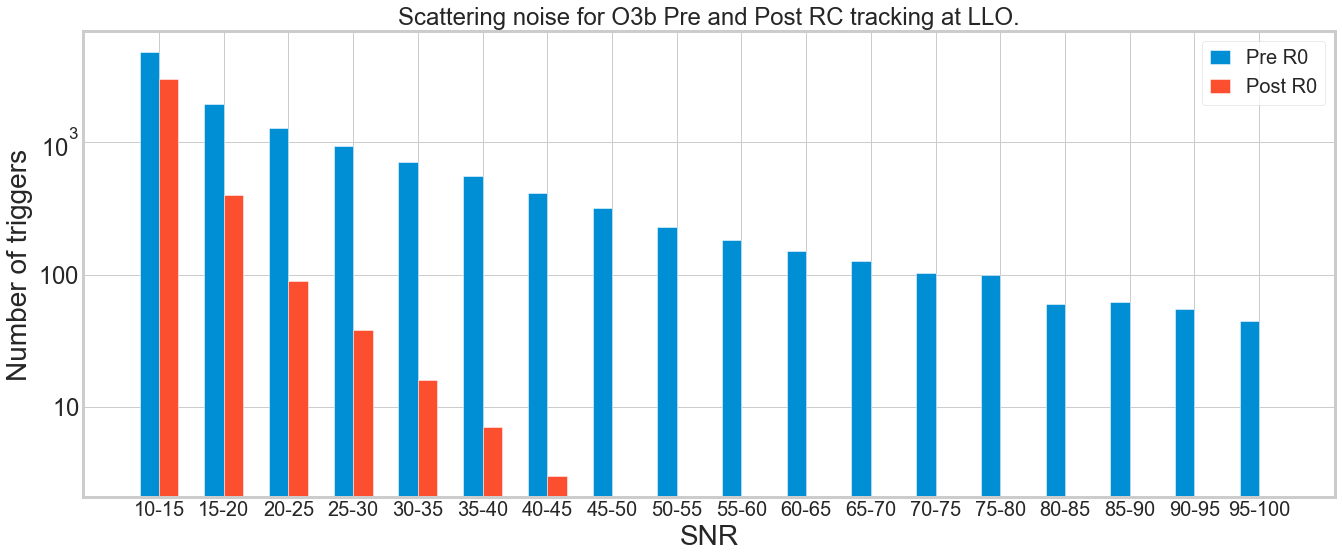

In [47]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_postsnrL1)-1)[:-1]
w = 0.3
plt.bar(x,count_presnrL1[:-1]/durfacL1,width=w,label='Pre R0')
plt.bar(x+w,count_postsnrL1[:-1],width=w,label='Post R0')
tcks = [str(division_postsnrL1[i])+'-'+str(division_postsnrL1[i+1]) for i in range(len(division_postsnrL1)-1)]
plt.xticks(x + w/2,tcks,size=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.yticks(fontsize=24)
plt.xlabel('SNR',fontsize=28)
plt.ylabel('Number of triggers',fontsize=28)
plt.title('Scattering noise for O3b Pre and Post RC tracking at LLO.',fontsize=24)
plt.legend(fontsize=20)
plt.show()

### P value calculation using Mann Whitney test

#### P value for difference in microseism ground motion

In [21]:
stat, p = mannwhitneyu(count_micropre/durfacL1, count_micropost)
stat,p

(179.0, 0.48835208668935587)

#### P value for difference in SNR

In [23]:
stat, p = mannwhitneyu(count_presnrL1/durfacL1,count_postsnrL1)
stat,p

(36.0, 9.712021388405567e-06)

#### P value for difference in earthquake band ground motion

In [24]:
stat, p = mannwhitneyu(count_eqpre/durfacL1,count_eqpost)
stat,p

(163.5, 0.1647705086360211)

### The p-values for the ground motion show that there is no significance difference in microseism and earthquake band for Pre and post RC tracking, whereas the p-value for SNR is well below the critical value of 0.05, which means that SNR is significantly different after the implementation of RC tracking.

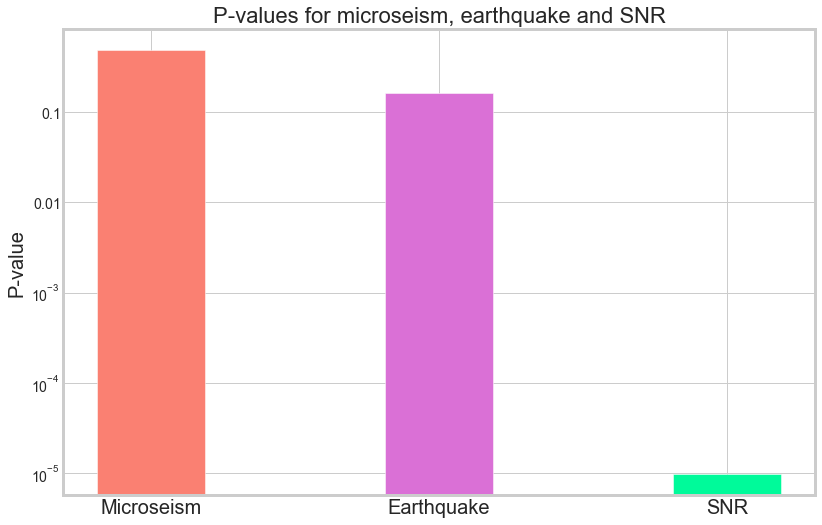

In [25]:
plt.figure(figsize=(12,8))
plt.bar([0.2,0.6,1.0],[0.488,0.164,9.72e-6],width=0.15,color=['salmon','orchid','mediumspringgreen'])
plt.ylabel('P-value',fontsize=20)
plt.yscale('log')
plt.xticks([0.2,0.6,1.0],['Microseism','Earthquake','SNR'],fontsize=20)
plt.title("P-values for microseism, earthquake and SNR",fontsize=22)
plt.show()